In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution
import os
from astropy.table import QTable, Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck13 as cosmo
from matplotlib.patches import Ellipse

from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

rc ('xtick',labelsize=13)
rc ('ytick',labelsize=13)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['figure.figsize'] = (24, 36)


In [2]:
LP=range(1,11)
qso_list=['TON1129','J0958+3224','J0959+3203','J1202-0129','J1202+0225','SBS1421+511','J1429+0321','J1431+0301','J1451+5914', 'J1700+2237']
orig_name=['TON1129','FBQSJ095820.9+322402','SDSSJ095914.85+320357.2','2MASXJ12022678-0129155','SDSSJ120233.08+022559.7','SBS1421+511','SDSSJ142940.73+032125.8','SDSSJ143145.99+030143.8','2MASXJ14515156+5914001','UVQSJ170043.71+223700.2']
host_haloid = [85746,85746,85746,140594,13927,144953,165082,165082,165707,147606]
hostID=['nsa85746', 'nsa85746','nsa85746','nsa140594','nsa13927','nsa144953', 'nsa165082','nsa165153','nsa165707','nsa147606']
z_qso=np.array([0.52611, 0.53060,0.56462,0.15069,0.27364,0.27622,0.25344,0.34055,0.29668,0.445132])
host_helio_vel=[1457.0,1457.0,1457.0, 1461.8, 1967.7,2221. ,1657.4,1657.4,2148.21,2795.2 ]
impact_param_host=[209.222285927, 13.4803426516, 157.119171001, 260.98587288, 235.973508037, 268.169740606,53.8712889489,244.117128625,155.099676124,271.80888]
raqso=[149.0967254638672, 149.58726501464844, 149.81187438964844, 180.6114959716797,180.6378631591797, 215.80909729003906, 217.41976928710938, 217.94163513183594,222.96473693847656,255.182125]
decqso=[32.60601806640625, 32.4006233215332, 32.06591033935547,-1.487576961517334,2.4332659244537354, 50.927024841308594, 3.3571879863739014, 3.028848886489868, 59.23335647583008, 22.616722222222222]
redshift = np.round(np.array(host_helio_vel)/3.e5, 5)
host_distance=[25.004747,25.004747,25.004747,23.120869, 0,34.035793,24.785791,24.785791, 33.376366,39.315384 ]

sightlines_table=Table([qso_list, orig_name, host_haloid,host_helio_vel, redshift, impact_param_host], names=("sightline", "QSO_name", "NAID", "host_helio_vel", "host_z", "b_host"))
sightlines_table.show_in_notebook()




idx,sightline,QSO_name,NAID,host_helio_vel,host_z,b_host
0,TON1129,TON1129,85746,1457.0,0.00486,209.222285927
1,J0958+3224,FBQSJ095820.9+322402,85746,1457.0,0.00486,13.4803426516
2,J0959+3203,SDSSJ095914.85+320357.2,85746,1457.0,0.00486,157.119171001
3,J1202-0129,2MASXJ12022678-0129155,140594,1461.8,0.00487,260.98587288
4,J1202+0225,SDSSJ120233.08+022559.7,13927,1967.7,0.00656,235.973508037
5,SBS1421+511,SBS1421+511,144953,2221.0,0.0074,268.169740606
6,J1429+0321,SDSSJ142940.73+032125.8,165082,1657.4,0.00552,53.8712889489
7,J1431+0301,SDSSJ143145.99+030143.8,165082,1657.4,0.00552,244.117128625
8,J1451+5914,2MASXJ14515156+5914001,165707,2148.21,0.00716,155.099676124
9,J1700+2237,UVQSJ170043.71+223700.2,147606,2795.2,0.00932,271.80888


In [9]:
lines = ['N I 1134','Fe II 1144','Si II 1190','S III 1190', 'Si II 1193','N I 1200','Si III 1206', 'HI 1215',  'NV 1238', 'NV 1242','S II 1250', 'S II 1253','S II 1258','Si II 1260',
         'OI 1302',  'Si II 1304','CII 1334',    'Si IV 1393',
         'Si IV 1402',
         'Si II 1526']
lines_wav =[1215.6700,1302.1685, 1334.5323,1200.66, 1134.66, 1238.8210,1242.8040, 1260.4221, 1193.2897, 1190.4158, 1526.7070, 1304.3702, 1206.5000, 1393.7602, 1402.729, 1144.9379, 1259.5180, 1253.8050, 1250.5780,1190.2030 ] 
lines_wav = sorted(lines_wav)
#osc_strength=[2.70, 1.80, 2.23, 2.20,2.02,1.71, 1.67, 1.51, 1.22, 2.29, 1.98, 3.17, 2.84, 2.54, 2.31, 2.05, 3.29, 2.85, 2.55, 1.98, 1.79, 1.32, 1.14, 0.83, 1.45]
lp=range(1,np.size(lines)+1)
lines_table=Table([lp,lines,lines_wav], names=("Lp","Species", 'Wavelength'))
lines_table.pprint_all()

 Lp   Species   Wavelength
--- ----------- ----------
  1    N I 1134    1134.66
  2  Fe II 1144  1144.9379
  3  Si II 1190   1190.203
  4  S III 1190  1190.4158
  5  Si II 1193  1193.2897
  6    N I 1200    1200.66
  7 Si III 1206     1206.5
  8     HI 1215    1215.67
  9     NV 1238   1238.821
 10     NV 1242   1242.804
 11   S II 1250   1250.578
 12   S II 1253   1253.805
 13   S II 1258   1259.518
 14  Si II 1260  1260.4221
 15     OI 1302  1302.1685
 16  Si II 1304  1304.3702
 17    CII 1334  1334.5323
 18  Si IV 1393  1393.7602
 19  Si IV 1402   1402.729
 20  Si II 1526   1526.707


In [3]:
directory='/Users/ahamanowicz/Dropbox/COS-SAGA/Targets/'

In [57]:
n=1
smoothing=3
sightline=sightlines_table['sightline'][n]
vhost = sightlines_table['host_helio_vel'][n]


Text(0.5, 1.0, 'CII 1334')

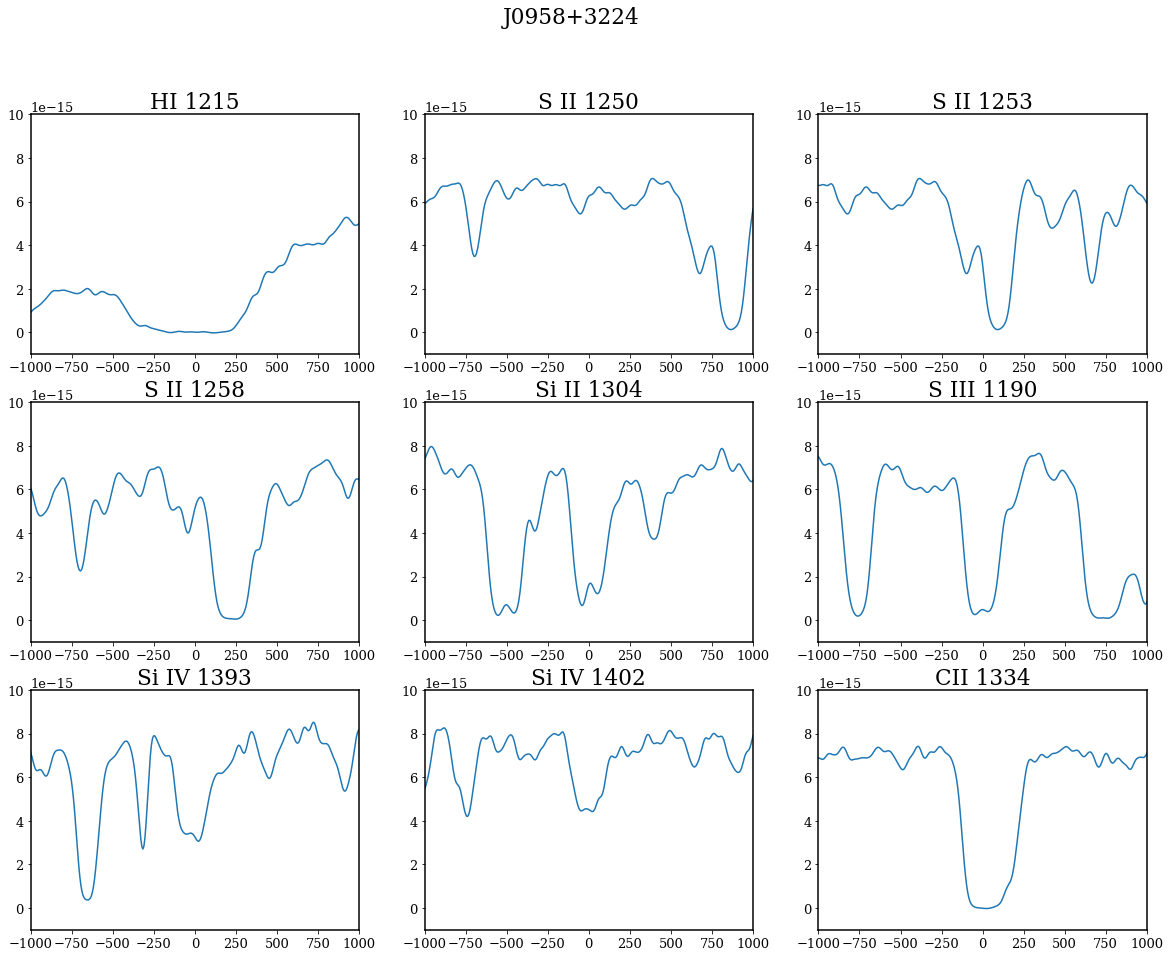

In [58]:
plt.figure(figsize=(20,15))
#read u=in the fits file
file=directory+sightline+"/Data/"+sightline+"_nbin3_coadd.fits"
hdul = fits.open(file)
#redshift
zhost=vhost/3.e5

wl = hdul['WAVELENGTH'].data
fx = hdul['FLUX'].data
fx_smooth = convolution.convolve(fx,convolution.Gaussian1DKernel(smoothing))

wl0 = wl/(1+zhost)
plt.suptitle(sightline)
plt.subplot(331)
#HI
a=7
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])
plt.subplot(332)
#Si II
a=10
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])
plt.subplot(333)
#Si II
a=11
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])
plt.subplot(334)
#Si II
a=12
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])
plt.subplot(335)
#Si II
a=15
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])

plt.subplot(336)

a=3
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])

plt.subplot(337)

a=17
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])

plt.subplot(338)

a=18
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])

plt.subplot(339)

a=16
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([-0.1e-14,1.0e-14])
plt.title(lines_table['Species'][a])

In [59]:
n=0
smoothing=3
sightline=sightlines_table['sightline'][n]
vhost = sightlines_table['host_helio_vel'][n]


Text(0.5, 1.0, 'CII 1334')

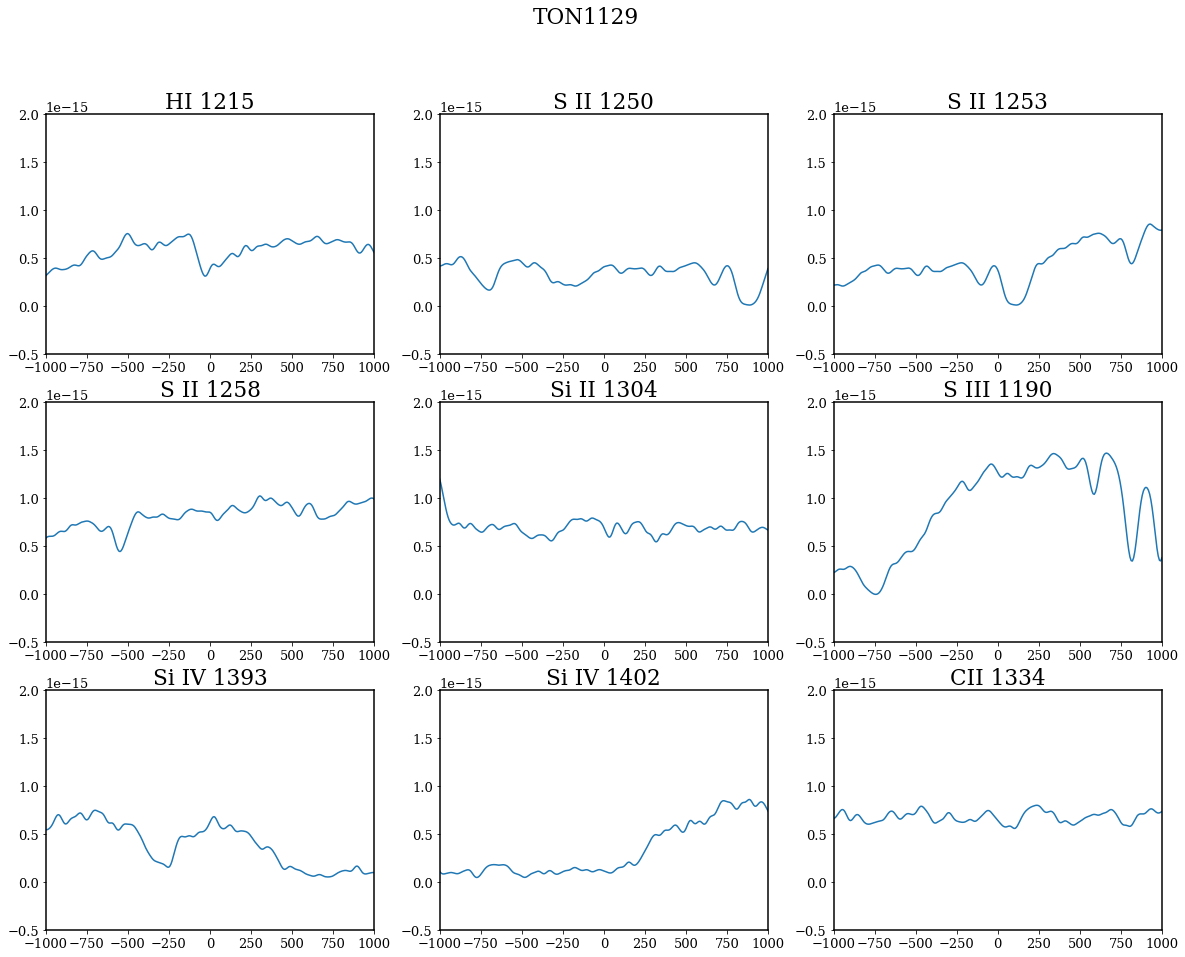

In [60]:
plt.figure(figsize=(20,15))
#read u=in the fits file
file=directory+sightline+"/Data/"+sightline+"_nbin3_coadd.fits"
hdul = fits.open(file)
#redshift
zhost=vhost/3.e5
ymax=2e-15
ymin = -0.5e-15
wl = hdul['WAVELENGTH'].data
fx = hdul['FLUX'].data
fx_smooth = convolution.convolve(fx,convolution.Gaussian1DKernel(smoothing))

wl0 = wl/(1+zhost)
plt.suptitle(sightline)
plt.subplot(331)
#HI
a=7
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(332)
#Si II
a=10
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(333)
#Si II
a=11
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(334)
#Si II
a=12
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(335)
#Si II
a=15
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(336)

a=3
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(337)

a=17
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(338)

a=18
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(339)

a=16
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

Text(0.5, 1.0, 'CII 1334')

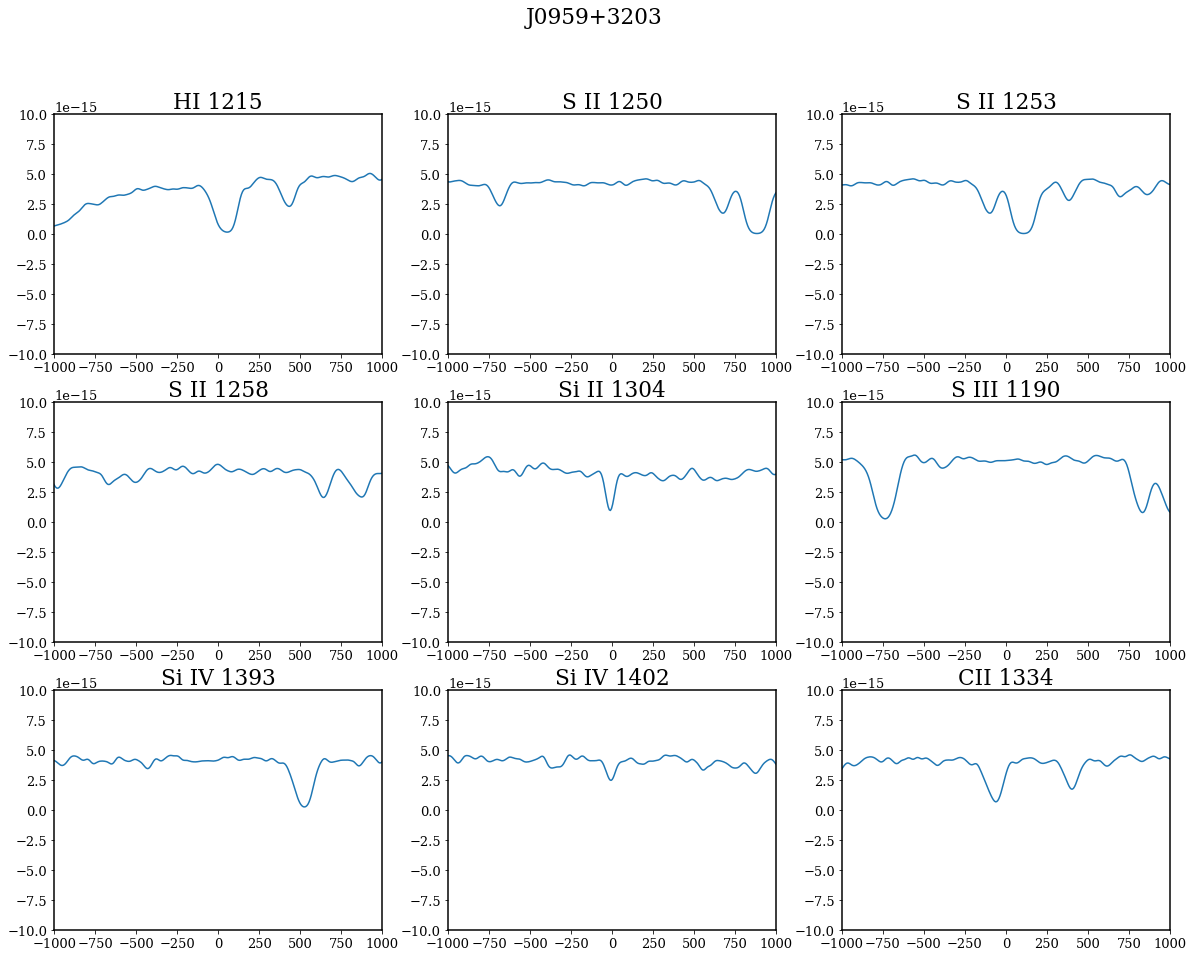

In [61]:
n=2
smoothing=3
sightline=sightlines_table['sightline'][n]
vhost = sightlines_table['host_helio_vel'][n]

plt.figure(figsize=(20,15))
#read u=in the fits file
file=directory+sightline+"/Data/"+sightline+"_nbin3_coadd.fits"
hdul = fits.open(file)
#redshift
zhost=vhost/3.e5
ymax=1e-14
ymin = -1e-14
wl = hdul['WAVELENGTH'].data
fx = hdul['FLUX'].data
fx_smooth = convolution.convolve(fx,convolution.Gaussian1DKernel(smoothing))

wl0 = wl/(1+zhost)
plt.suptitle(sightline)
plt.subplot(331)
#HI
a=7
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(332)
#Si II
a=10
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(333)
#Si II
a=11
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(334)
#Si II
a=12
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])
plt.subplot(335)
#Si II
a=15
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(336)

a=3
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(337)

a=17
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(338)

a=18
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])

plt.subplot(339)

a=16
line = lines_table['Wavelength'][a]
v_el = (wl0 - line)/line * 3e5
plt.plot(v_el, fx_smooth)
plt.xlim([-1000,1000])
plt.ylim([ymin,ymax])
plt.title(lines_table['Species'][a])